# 正弦嵌入

深度学习模型的输入通常表示空间、时间或时空网格上的位置。为了丰富这些坐标信息，可以引入位置嵌入来提高模型在整个域上的泛化能力。本教程重点介绍正弦位置嵌入。

正弦嵌入将输入编码为周期函数（正弦和余弦），从而将低维坐标提升到更丰富的谱表示中。这种谱提升增强了模型捕捉精细尺度变化和高频动态的能力。

## 一维设置

为了建立直观理解，考虑一个简单的一维例子。令 $x \in \mathbb{R}$ 为单个输入，定义嵌入函数：

$$g: \mathbb{R} \rightarrow \mathbb{R}^{2 L}, \quad g(x)=[\sin (x), \  \cos (x), \ \sin (2 x), \ \cos (2 x), \ldots, \ \sin (L x), \ \cos (L x)],$$

其中 $L$ 定义了我们要用于嵌入的频率数量。每一对正弦和余弦项引入一个更高的频率，丰富了位置信息的表示方式。

这个思想自然地扩展到整个一维输入。令 $\vec{x} \in \mathbb{R}^N$ 表示 $N$ 个点的离散化域，则嵌入函数变为：

$$g: \mathbb{R}^N \rightarrow \mathbb{R}^{N \times 2 L}, \quad g(\vec{x})=\operatorname{concat}(\sin (\vec{x}), \cos (\vec{x}), \sin (2 \vec{x}), \cos (2 \vec{x}), \ldots, \sin (L \vec{x}), \cos (L \vec{x})),$$

其中  $\operatorname{concat}$ 表示将多个向量拼接成一个向量。 在实践中，原始坐标及其嵌入都传递给模型：

$$\operatorname{input}(\vec{x})=\operatorname{concat}(\vec{x}, \ g(\vec{x})) \in \mathbb{R}^{N \times 2 L + 1},$$

在保留原始输入的同时，用一系列频率分量对其进行增强。

> 注意：这里的 $\vec{x}$ 可以看成一维空间中的离散点集，例如时间序列中的时间点或空间网格中的位置。它的各个分量的排列顺序并没有实际意义。比如说，$\vec{x}=(1,3,2,4,5)^T$，那么嵌入后得到 
> $$
    \text{input}(\vec{x}) = \begin{bmatrix}
    1 & \sin(1) & \cos(1) & \sin(2) & \cos(2) & \ldots & \sin(L) & \cos(L) \\
    3 & \sin(3) & \cos(3) & \sin(6) & \cos(6) & \ldots & \sin(3L) & \cos(3L) \\
    2 & \sin(2) & \cos(2) & \sin(4) & \cos(4) & \ldots & \sin(2L) & \cos(2L) \\
    4 & \sin(4) & \cos(4) & \sin(8) & \cos(8) & \ldots & \sin(4L) & \cos(4L) \\
    5 & \sin(5) & \cos(5) & \sin(10) & \cos(10) & \ldots & \sin(5L) & \cos(5L)
    \end{bmatrix}
$$

### 域归一化

应用正弦嵌入时，通常将输入坐标归一化到与正弦和余弦函数的自然周期对齐的周期区间内。例如，包含 $N$ 个点的一维空间域 $\vec{x} \in[0,1]$ 可以重新缩放为：

$$\vec{x}^{\prime}=2 \pi \vec{x},$$

使得 $\vec{x}^{\prime} \in[0,2 \pi]$。

这种映射保留了采样点数量 $N$ 和域的整体形状，同时确保最低频率的正弦和余弦分量在区间内恰好完成一个完整的振荡。

### 选择 $L$ 以满足Nyquist准则

回忆：Nyquist-Shannon采样定理指出，通过采样能够复现的最高频率分量受限于采样频率的一半，称为Nyquist频率。


对于包含 $N$ 个点的域（已经归一化到 $[0, 2\pi]$），Nyquist频率为采样频率的一半：

$$f_{\text{Nyquist}} = \frac{N}{2}.$$

对于上面定义的正弦嵌入，Nyquist约束变为：

$$L < \frac{N}{2}.$$

Nyquist频率表示采样信号时能够正确捕获的最高频率，等于采样率的一半。如果使用高于此限制的频率，它们将不会表示为真正的高频，而是表现为较低的频率，产生称为混叠的失真。这就是为什么我们必须确保嵌入中的最高频率不超过Nyquist极限。

### 可视化正弦嵌入

下面，我们可视化一个空间输入域 $\vec{x} \in[0,1]$ 的正弦嵌入，该域包含1000个等距点，使用 $L = 3$ 个频率级别。



对于给定的频率数 3，满足Nyquist-Shannon采样定理。


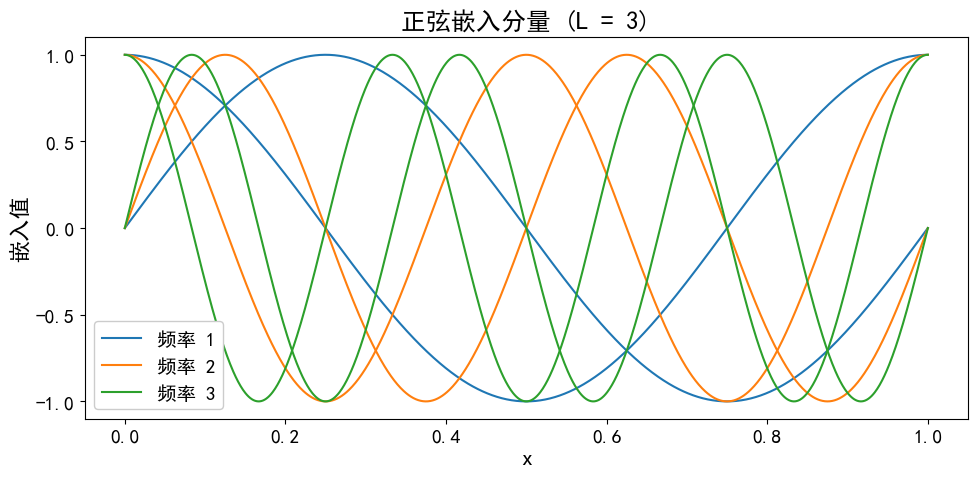

In [56]:
# 导入所需的库
import torch
import matplotlib.pyplot as plt
import numpy as np
from neuralop.layers.embeddings import SinusoidalEmbedding

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 设置默认字体大小以便更好阅读
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
    }
)

device = "cpu"  # 使用CPU设备

# 定义空间域和频率数量
# 在[0, 1]区间创建1000个等距点，并归一化到[0, 2π]以便进行正确的正弦嵌入
x = torch.linspace(0, 1, 1000)
x_normalized = torch.linspace(0, 2 * torch.pi, len(x))
# 嵌入的频率级别数
L = 3

# 检查频率数量是否满足Nyquist准则
if L < len(x_normalized)/2:
    print(f"对于给定的频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的频率数 {L}，违反Nyquist-Shannon采样定理。")

# 构建嵌入：[sin(x), cos(x), sin(2x), cos(2x), ...]
# 每个频率级别贡献一对正弦和余弦
g = []
for l in range(1, L + 1):
    g.append(torch.sin(l * x_normalized))
    g.append(torch.cos(l * x_normalized))

# 通过连接原始输入和嵌入来构建输入
# 这保留了原始坐标，同时增加了谱信息
input_arr = np.asarray([x, *g])
input_tensor = torch.tensor(input_arr)

# 绘制嵌入分量
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 5))
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx = 2 * freq_idx + 1
    cos_idx = 2 * freq_idx + 2

    plt.plot(x, input_tensor[sin_idx], color=color, label=f"频率 {freq_idx + 1}")
    plt.plot(x, input_tensor[cos_idx], color=color)

plt.xlabel("x", fontsize=16)
plt.ylabel("嵌入值", fontsize=16)
plt.title("正弦嵌入分量 (L = 3)", fontsize=18)
plt.legend(loc="lower left", framealpha=1.0, fontsize=14)
plt.locator_params(axis="y", nbins=5)
plt.tight_layout()
plt.show()



## 编码常数参数

正弦嵌入的一个特别有用的扩展是它们能够编码常数参数。考虑一个设置，其中你有一个标量参数 $m$（如材料属性、边界条件或物理常数），你希望将其输入模型。我们可以通过调制正弦分量的振幅或频率，用周期函数表示 $m$，而不是将其视为固定标量输入。

**1. 振幅调制：** 通过缩放正弦函数的振幅来编码 $m$，我们定义嵌入为：

$$m \rightarrow m g(\vec{x}),$$

其中嵌入 $g(\vec{x})$ 的每个元素都乘以 $m$。

**2. 频率调制：** 或者，通过缩放频率来编码 $m$，我们定义：

$$m \rightarrow g(m\vec{x})$$

其中 $m$ 乘以每个正弦分量的输入参数。

当通过频率调制编码常数参数时，必须注意确保满足Nyquist准则。在这种情况下，调制因子 $m$ 缩放频率，Nyquist约束变为 $L < \frac{N}{2m}$。

下面，我们演示通过振幅和频率调制编码参数 $m = 2.5$ 的示例。



对于给定的参数 2.5 和频率数 3，满足Nyquist-Shannon采样定理。


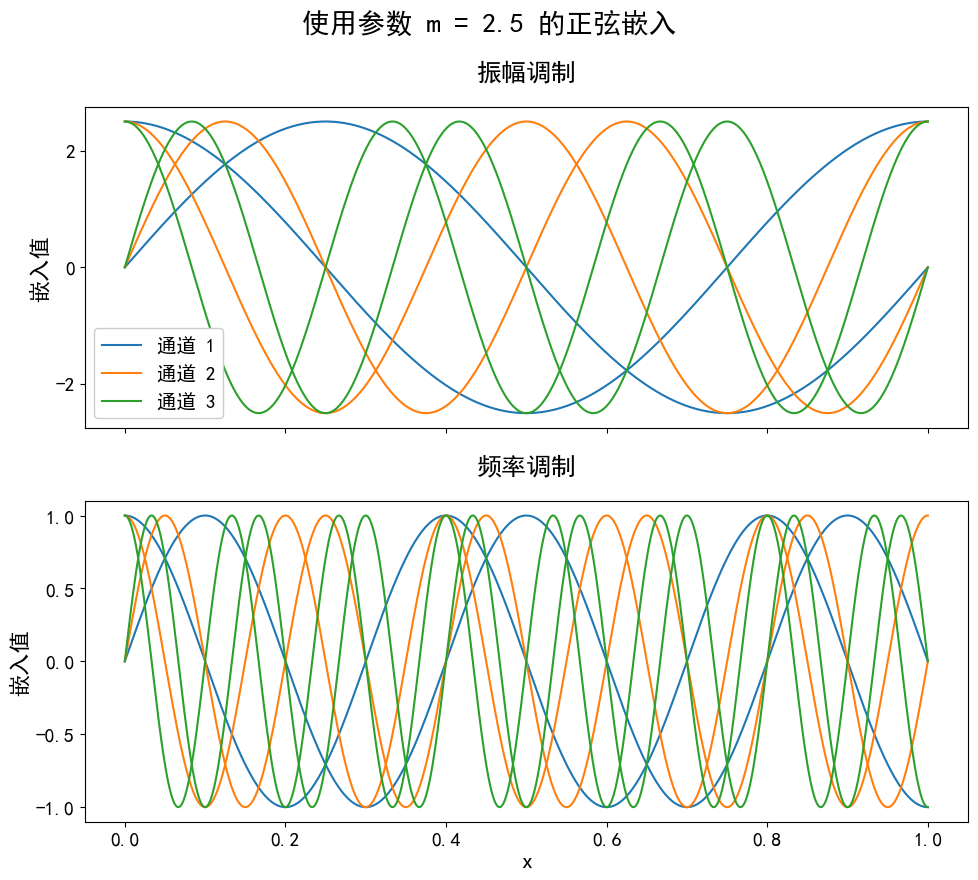

In [57]:
# 定义空间域和频率数量
x = torch.linspace(0, 1, 1000)
x_normalized = torch.linspace(0, 2 * torch.pi, len(x))
L = 3

# 定义要编码的参数
m = 2.5
m_tensor = torch.tensor([m])

# 检查频率数量和参数是否满足Nyquist准则
if L <= len(x_normalized)/(2 * m):
    print(f"对于给定的参数 {m} 和频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的参数 {m} 和频率数 {L}，违反Nyquist-Shannon采样定理。")

# 构建振幅调制嵌入：m * g(x)
g_amplitude = []
for l in range(1, L + 1):
    g_amplitude.append(torch.sin(l * x_normalized) * m_tensor)
    g_amplitude.append(torch.cos(l * x_normalized) * m_tensor)

# 构建频率调制嵌入：g(m * x)
g_frequency = []
for l in range(1, L + 1):
    g_frequency.append(torch.sin(l * x_normalized * m_tensor))
    g_frequency.append(torch.cos(l * x_normalized * m_tensor))

# 转换为数组以便可视化
input_amplitude = torch.tensor(np.asarray([x, *g_amplitude]))
input_frequency = torch.tensor(np.asarray([x, *g_frequency]))

# 绘制两种嵌入
colors = plt.cm.tab10.colors
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

## 振幅调制
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx, cos_idx = 2 * freq_idx + 1, 2 * freq_idx + 2
    axes[0].plot(x, input_amplitude[sin_idx], color=color, label=f"通道 {freq_idx + 1}")
    axes[0].plot(x, input_amplitude[cos_idx], color=color)
axes[0].set_title("振幅调制", fontsize=18, pad=20)
axes[0].set_ylabel("嵌入值", fontsize=16)
axes[0].legend(loc="lower left", framealpha=1.0, fontsize=14)
axes[0].locator_params(axis="y", nbins=5)

## 频率调制
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx, cos_idx = 2 * freq_idx + 1, 2 * freq_idx + 2
    axes[1].plot(x, input_frequency[sin_idx], color=color, label=f"通道 {freq_idx + 1}")
    axes[1].plot(x, input_frequency[cos_idx], color=color)
axes[1].set_title("频率调制", fontsize=18, pad=20)
axes[1].set_ylabel("嵌入值", fontsize=16)
axes[1].set_xlabel("x", fontsize=16)
axes[1].locator_params(axis="y", nbins=5)

plt.suptitle(f"使用参数 m = {m} 的正弦嵌入", y=0.98, fontsize=20)
plt.tight_layout()
plt.show()



## Neural Operator SinusoidalEmbedding 类

``neuralop`` 库提供了一个统一的正弦位置嵌入类 ``neuralop.layers.embeddings.SinusoidalEmbedding``，包含以下嵌入技术：

- ``transformer`` - Vaswani, A. 等人 (2017), "Attention Is All You Need"。
- ``nerf`` - Mildenhall, B. 等人 (2020), "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis"。

`SinusoidalEmbedding` 类期望输入形状为： ``(batch_size, N, input_channels)`` 或 ``(N, input_channels)``，其中 $N$ 是离散点的数量， ``input_channels`` 是每个点的输入维度（对于一维输入为1）。输出形状为： ``(batch_size, N, input_channels * (2 * L + 1))`` 或 ``(N, input_channels * (2 * L + 1))``。

### 嵌入变体

令 $\vec{x} \in \mathbb{R}^N$ 表示由 $N$ 个离散点组成的一维输入域。嵌入函数 $g: \mathbb{R}^N \rightarrow \mathbb{R}^{N \times 2L}$ 将每个输入值 $x_n$ 映射到一个 $2L$ 维向量，该向量由在不同频率下评估的正弦和余弦项组成。每种嵌入类型以不同的方式定义这些频率，从而产生不同的表示。

**1. Transformer 风格嵌入：** 对于 $0 \leq k < L$：

$$g(\vec{x})_{:, 2 k}=\sin \left(\frac{\vec{x}}{\text { max positions }^{k / L}}\right), \quad g(\vec{x})_{:, 2 k+1}=\cos \left(\frac{\vec{x}}{\text { max positions }^{k / L}}\right) .$$

这里，$\text{max positions}$ 控制嵌入的最大位置。

**2. NeRF 风格嵌入：** 对于 $0 \leq k < L$：

$$g(\vec{x})_{:, 2 k}=\sin \left(2^k \pi \vec{x}\right), \quad g(\vec{x})_{:, 2 k+1}=\cos \left(2^k \pi \vec{x}\right) .$$

为了确保满足Nyquist准则，对于 Transformer 风格嵌入，嵌入频率应满足：$f_{\max} < f_{\text{Nyquist}}$。

对于 NeRF 风格嵌入：

$$2^{L-1} < \frac{N}{2} \ \ \implies \ \  L < 1 + \log_2\left(\frac{N}{2}\right).$$

下面，我们包含了使用 `SinusoidalEmbedding` 类进行 transformer 和 NeRF 风格嵌入的示例。



对于给定的频率数 3，满足Nyquist-Shannon采样定理。


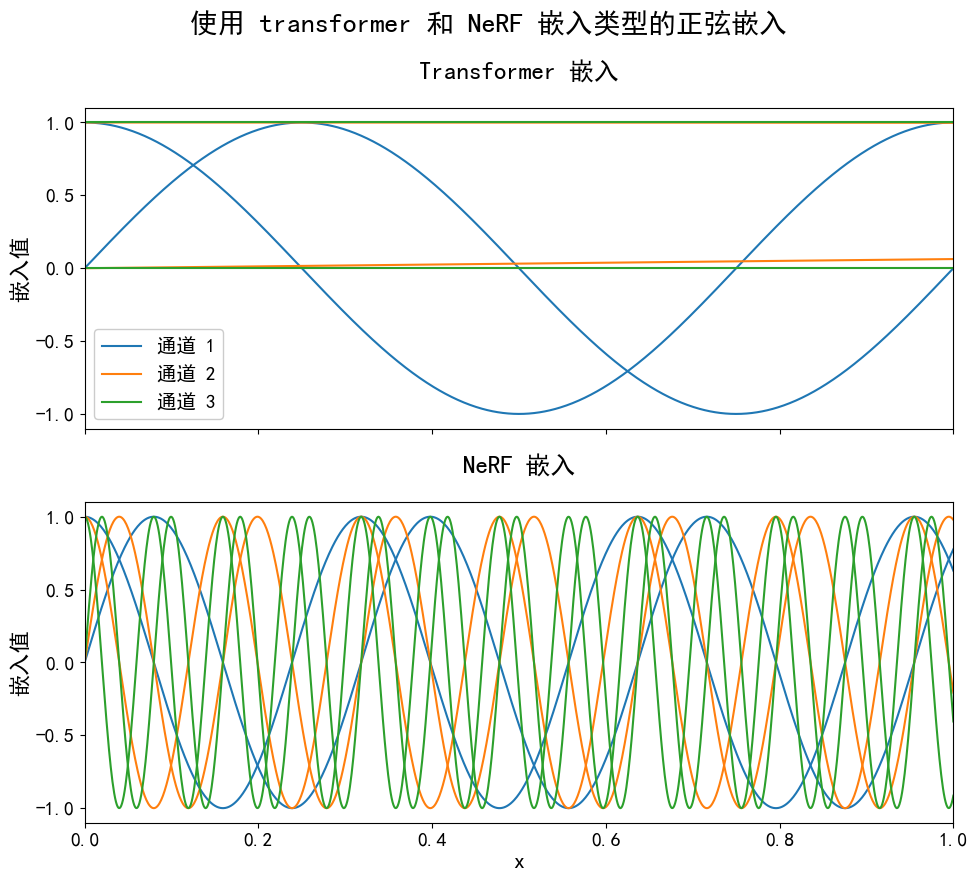

In [58]:
# 定义空间域和频率数量
x = torch.linspace(0, 1, 1000)
x_normalized = torch.linspace(0, 2 * torch.pi, len(x)).reshape(-1, 1)
L = 3

# 检查频率数量是否满足Nyquist准则
if L <= 1 + torch.log2(torch.tensor(len(x_normalized)/2 )):
    print(f"对于给定的频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的频率数 {L}，违反Nyquist-Shannon采样定理。")

# 定义 transformer 嵌入
# max_positions 控制 transformer 风格嵌入中的频率缩放
max_positions = 1000
transformer_embedder = SinusoidalEmbedding(
    in_channels=1,
    num_frequencies=L,
    embedding_type="transformer",
    max_positions=max_positions,
).to(device)

# 应用 transformer 风格嵌入
transformer_embedding = transformer_embedder(x_normalized).permute(1, 0)

# 定义 NeRF 嵌入
nerf_embedder = SinusoidalEmbedding(
    in_channels=1, num_frequencies=L, embedding_type="nerf"
).to(device)

# 应用 NeRF 风格嵌入
nerf_embedding = nerf_embedder(x_normalized).permute(1, 0)

# 绘制两种嵌入
colors = plt.cm.tab10.colors
fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

## Transformer 嵌入
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx, cos_idx = 2 * freq_idx, 2 * freq_idx + 1

    axes[0].plot(x, transformer_embedding[sin_idx], color=color, label=f"通道 {freq_idx + 1}")
    axes[0].plot(x, transformer_embedding[cos_idx], color=color)

axes[0].set_title("Transformer 嵌入", fontsize=18, pad=20)
axes[0].set_ylabel("嵌入值", fontsize=16)
axes[0].legend(loc="lower left", framealpha=1.0, fontsize=14)
axes[0].locator_params(axis="y", nbins=5)

# 设置显示范围
axes[0].set_xlim(0, 1)


## NeRF 嵌入
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx, cos_idx = 2 * freq_idx, 2 * freq_idx + 1

    axes[1].plot(x, nerf_embedding[sin_idx], color=color, label=f"通道 {freq_idx + 1}")
    axes[1].plot(x, nerf_embedding[cos_idx], color=color)

axes[1].set_title("NeRF 嵌入", fontsize=18, pad=20)
axes[1].set_xlabel("x", fontsize=16)
axes[1].set_ylabel("嵌入值", fontsize=16)
axes[1].locator_params(axis="y", nbins=5)

plt.suptitle("使用 transformer 和 NeRF 嵌入类型的正弦嵌入", y=0.98, fontsize=20)
plt.tight_layout()
plt.show()



### 使用 NeuralOp 类编码常数参数

类似于前面的说明性示例，我们也可以在将标量参数 $m$ 传递给模型之前对其进行编码。再次强调，必须注意确保满足Nyquist准则。

在 Transformer 风格嵌入中，为了避免混叠，嵌入频率仍应满足：

$$f_{\max} < f_{\text{Nyquist}}.$$

对于 NeRF 风格嵌入，修改后的约束变为：

$$2^{L-1}m < \frac{N}{2} \implies L < 1 + \log_2\left(\frac{N}{2m}\right).$$

下面，我们演示通过 NeRF 风格嵌入的频率调制编码参数 $m = 2.5$ 的示例。



对于给定的参数 2.5 和频率数 3，满足Nyquist-Shannon采样定理。


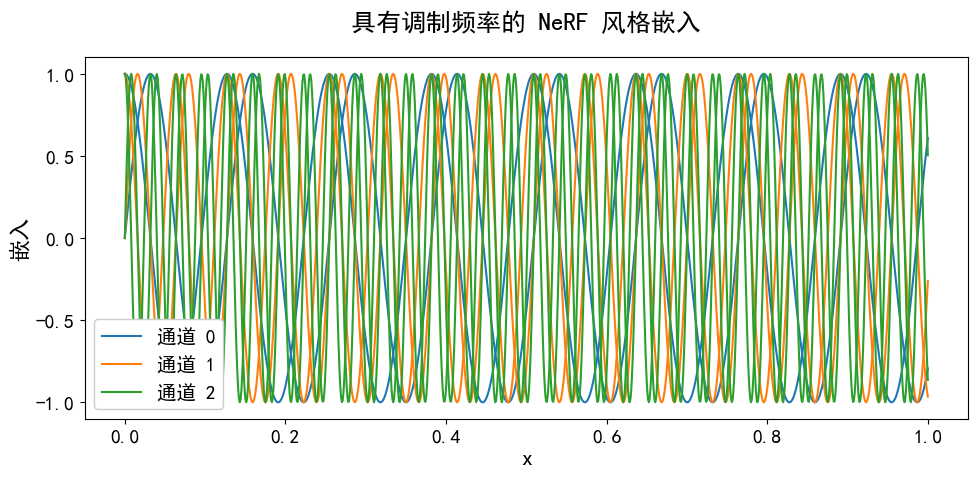

In [59]:
# 定义空间域和频率数量
x = torch.linspace(0, 1, 1000)
x_normalized = torch.linspace(0, 2 * torch.pi, len(x)).reshape(-1, 1)
L = 3

# 定义要编码的参数
m = 2.5
m_tensor = torch.tensor([m])

# 检查频率数量和参数是否满足Nyquist准则
if L <= 1 + torch.log2(torch.tensor(len(x_normalized)/2 * m)):
    print(f"对于给定的参数 {m} 和频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的参数 {m} 和频率数 {L}，违反Nyquist-Shannon采样定理。")

# 定义 NeRF 嵌入
nerf_embedder = SinusoidalEmbedding(
    in_channels=1, num_frequencies=L, embedding_type="nerf"
).to(device)

# 应用频率调制：在嵌入之前将输入乘以参数
# 这通过参数 m 缩放所有频率
nerf_embedding = nerf_embedder(x_normalized * m_tensor).permute(1, 0)

# 绘制嵌入
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 5))
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx = 2 * freq_idx
    cos_idx = 2 * freq_idx + 1

    plt.plot(x, nerf_embedding[sin_idx], color=color, label=f"通道 {freq_idx}")
    plt.plot(x, nerf_embedding[cos_idx], color=color)

plt.xlabel("x", fontsize=16)
plt.ylabel("嵌入", fontsize=16)
plt.title("具有调制频率的 NeRF 风格嵌入", fontsize=18, pad=20)
plt.legend(loc="lower left", framealpha=1.0, fontsize=14)
plt.locator_params(axis="y", nbins=5)
plt.tight_layout()
plt.show()



类似地，我们可以通过振幅调制编码参数 $m = 2.5$，下面我们展示一个使用 NeRF 风格嵌入的示例。



对于给定的频率数 3，满足Nyquist-Shannon采样定理。


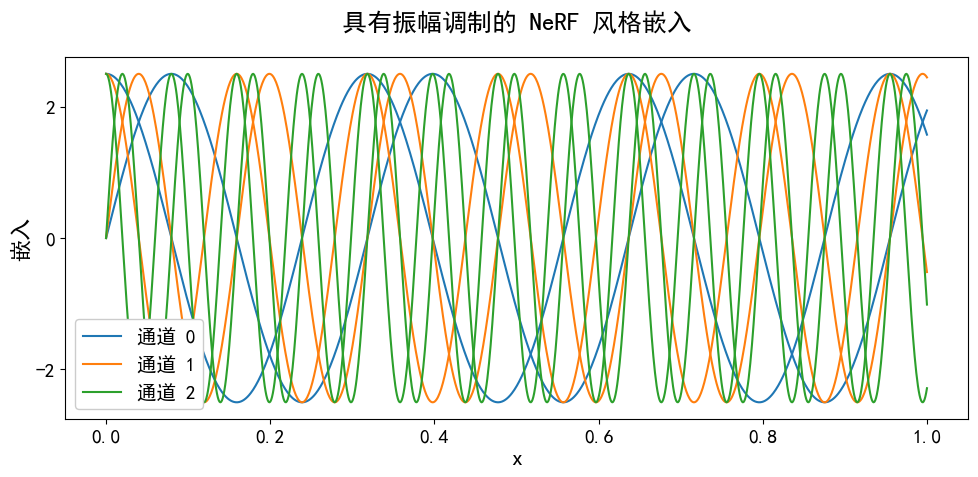

In [60]:
# 定义空间域和频率数量
x = torch.linspace(0, 1, 1000)
x_normalized = torch.linspace(0, 2 * torch.pi, len(x)).reshape(-1, 1)
L = 3

# 定义要编码的参数
m = 2.5
m_tensor = torch.tensor([m])

# 检查频率数量是否满足Nyquist准则
if L <= 1 + torch.log2(torch.tensor(len(x_normalized)/2)):
    print(f"对于给定的频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的频率数 {L}，违反Nyquist-Shannon采样定理。")

# 定义嵌入
nerf_embedder = SinusoidalEmbedding(
    in_channels=1, num_frequencies=L, embedding_type="nerf"
).to(device)

# 应用振幅调制：计算后乘以参数
# 这通过参数 m 缩放所有嵌入分量
nerf_embedding = nerf_embedder(x_normalized).permute(1, 0) * m_tensor

# 绘制嵌入
colors = plt.cm.tab10.colors

plt.figure(figsize=(10, 5))
for freq_idx in range(L):
    color = colors[freq_idx % len(colors)]
    sin_idx = 2 * freq_idx
    cos_idx = 2 * freq_idx + 1

    plt.plot(x, nerf_embedding[sin_idx], color=color, label=f"通道 {freq_idx}")
    plt.plot(x, nerf_embedding[cos_idx], color=color)

plt.xlabel("x", fontsize=16)
plt.ylabel("嵌入", fontsize=16)
plt.title("具有振幅调制的 NeRF 风格嵌入", fontsize=18, pad=20)
plt.legend(loc="lower left", framealpha=1.0, fontsize=14)
plt.locator_params(axis="y", nbins=5)
plt.tight_layout()
plt.show()



## 应用于傅里叶神经算子 (FNOs)

傅里叶神经算子 (FNOs) 通过在频域中操作来学习函数之间的映射。它们使用傅里叶变换将数据表示为正弦和余弦分量的组合，使它们能够捕获跨频率的复杂、多尺度交互。鉴于正弦嵌入也将低维数据提升到更丰富的谱表示中，它们自然地补充了 FNOs。这种协同作用使正弦嵌入对神经算子架构特别有效。

在神经算子的一般设置中，我们强烈建议选择频率数 $L$ 以使Nyquist准则不被违反。这可以通过遵循我们之前为 transformer 风格和 NeRF 风格嵌入选择 $L$ 的指南来完成。

当处理具有指定傅里叶模式数 $n_{\text{modes}}$ 的 FNOs 时，最高嵌入频率理想情况下也应保持在 $n_{\text{modes}}$ 以下，因为更高的频率将被归零，并且不会被谱卷积操作处理。

对于 NeRF 风格嵌入，这个条件导致 $L$ 的明确上限：

$$2^{L-1} < n_{\text{modes}} \ \ \implies \ \  L < 1 + \log_2\left(n_{\text{modes}}\right).$$

## 高维设置

令 $X \in \mathbb{R}^{d \times N}$ 表示一个 $d$ 维输入域，由 $N$ 个离散点组成，其中每一行 $\vec{x}_{i} \in \mathbb{R}^N$ 对应于沿第 $i$ 个空间或时间维度的采样坐标。因此，$X$ 的每一列表示 $d$ 维域中的单个点 $\vec{x}_{:,j} \in \mathbb{R}^d$。

基于前面介绍的一维嵌入函数 $g$，我们定义多维嵌入：

$$h: \mathbb{R}^{d \times N} \ \  \rightarrow \ \ \mathbb{R}^{N \times 2 L d}, \quad h(X)=\operatorname{concat}\left(g\left(\vec{x}_1\right), g\left(\vec{x}_2\right), \ldots, g\left(\vec{x}_d\right)\right),$$

其中每个 $\vec{x}_i$ 表示沿第 $i$ 个输入维度的采样域。

> 可以看出：多维嵌入函数 $h$ 将一维嵌入函数 $g$ 独立应用于每个坐标维度，并将得到的嵌入沿着特征轴连接。这种方法允许模型分别捕获每个维度的频率模式，同时保持整体结构。

下面，我们包含一个使用 `SinusoidalEmbedding` 类为 3D 输入构建 NeRF 风格嵌入的示例。



In [61]:
# 定义一维空间域并通过重复归一化的一维域构建 3D 输入
dim = 3
x_1d = torch.linspace(0, 1, 1000)
# 归一化到 [0, 2π] 并添加通道维度
x_normalized_1d = torch.linspace(0, 2 * torch.pi, x_1d.size(0), device=x_1d.device).unsqueeze(1)
# 为 3D 输入重复：形状 (N, 3)
x_normalized = x_normalized_1d.repeat(1, dim)
print(f"x_normalized.shape: {x_normalized.shape}")

# 定义频率数量
L = 3

# 检查频率数量是否满足Nyquist准则
# 对于多维输入，约束独立应用于每个维度
if L <= 1 + torch.log2(torch.tensor(len(x_normalized)/2)):
    print(f"对于给定的频率数 {L}，满足Nyquist-Shannon采样定理。")
else:
    print(f"对于给定的频率数 {L}，违反Nyquist-Shannon采样定理。")

# 定义 transformer 嵌入
max_positions = 1000
transformer_embedder = SinusoidalEmbedding(
    in_channels=3,
    num_frequencies=L,
    embedding_type="transformer",
    max_positions=max_positions,
).to(device)

# 应用 transformer 风格嵌入
transformer_embedding = transformer_embedder(x_normalized).permute(1, 0)

# 定义 NeRF 嵌入
nerf_embedder = SinusoidalEmbedding(
    in_channels=dim, num_frequencies=L, embedding_type="nerf"
).to(device)

# 应用 NeRF 风格嵌入
nerf_embedding = nerf_embedder(x_normalized).permute(1, 0)


x_normalized.shape: torch.Size([1000, 3])
对于给定的频率数 3，满足Nyquist-Shannon采样定理。
